# 🎵 Reconnaissance d'Émotion Audio avec Deep Learning\n
\n
Ce notebook détaille étape par étape la création d'une Intelligence Artificielle capable de détecter l'émotion (Colère, Joie, Tristesse, etc.) dans la voix humaine.\n
\n
Nous utiliserons le dataset **CREMA-D** et une approche robuste basée sur :\n
1.  **MFCC (Mel-Frequency Cepstral Coefficients)** pour le traitement du signal.\n
2.  **CNN 1D (Réseau de Neurones Convolutif)** pour la classification.\n
\n
---

## 1. Configuration et Imports\n
Importation des librairies nécessaires pour le traitement audio (`librosa`), la manipulation de données (`pandas`, `numpy`) et le Deep Learning (`tensorflow`).

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CONFIGURATION
---

In [6]:
# Chemin vers votre dossier contenant les fichiers .wav
DATA_PATH = "./AudioWAV"

# Configuration Audio
SAMPLE_RATE = 22050  # Fréquence d'échantillonnage (Hz)
DURATION = 2.5       # Durée fixe en secondes pour chaque extrait
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)

## 2. Chargement des Données
Les fichiers du dataset CREMA-D suivent une convention de nommage précise : `ActorID_SentenceID_Emotion_Level.wav`.
Nous allons parcourir le dossier pour extraire l'émotion de chaque fichier directement depuis son nom."

In [7]:
def load_data(data_path):
    data = []

    # Mapping des codes vers des noms lisibles
    emotion_map = {
        'ANG': 'Colère',
        'DIS': 'Dégoût',
        'FEA': 'Peur',
        'HAP': 'Joie',
        'NEU': 'Neutre',
        'SAD': 'Tristesse'
    }

    if not os.path.exists(data_path):
        print(f"ERREUR: Le dossier {data_path} n'existe pas.")
        return pd.DataFrame()

    print("Exploration des fichiers audio...")

    for filename in os.listdir(data_path):
        if filename.endswith('.wav'):
            # Structure: 1001_DFA_ANG_XX.wav
            parts = filename.split('_')

            if len(parts) >= 3:
                emotion_code = parts[2]

                if emotion_code in emotion_map:
                    data.append({
                        'path': os.path.join(data_path, filename),
                        'label': emotion_code,
                        'actor': parts[0]
                    })

    return pd.DataFrame(data)

In [8]:
# Exécution du chargement
df = load_data(DATA_PATH)
print(f"Fichiers trouvés : {len(df)}")

Exploration des fichiers audio...
Fichiers trouvés : 7442


C:\Users\arthu\AppData\Local\Temp\ipykernel_27324\168198241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


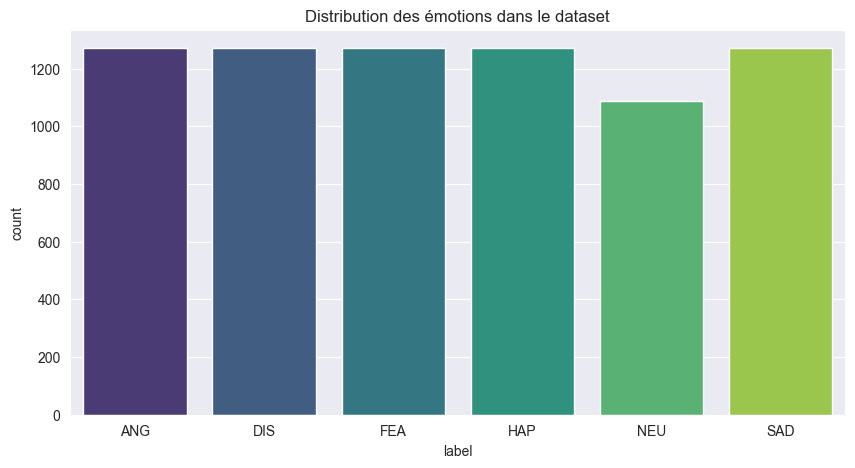

In [9]:
# Affichage de la distribution si des données sont trouvées
if not df.empty:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title('Distribution des émotions dans le dataset')
    plt.show()

## 3. Extraction des Caractéristiques (Feature Extraction)
C'est l'étape critique. Un ordinateur ne "comprend" pas le son brut. Nous devons le transformer en matrice numérique.

Nous utilisons les **MFCC (Mel-Frequency Cepstral Coefficients)**. Imaginez cela comme une "empreinte digitale" du son qui capture le timbre de la voix sans se soucier de ce qui est dit.

**Traitements effectués :**
1.  **Chargement** : Lecture du fichier .wav avec `librosa`.
2.  **Padding/Truncating** : Tous les fichiers n'ont pas la même durée. Pour que le réseau de neurones fonctionne, nous devons forcer une taille unique (ici 2.5 secondes). On coupe si c'est trop long, on ajoute du silence si c'est trop court.
3.  **MFCC** : Calcul des coefficients.

In [10]:
def extract_features(file_path):
    try:
        # 1. Chargement de l'audio
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # 2. Padding / Truncating (Uniformisation de la longueur)
        if len(audio) > SAMPLES_PER_TRACK:
            # Si trop long, on coupe au milieu
            center = len(audio) // 2
            start = center - (SAMPLES_PER_TRACK // 2)
            audio = audio[start : start + SAMPLES_PER_TRACK]
        else:
            # Si trop court, on ajoute des zéros à la fin
            padding = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # 3. Extraction MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

        # Transposition pour avoir (Temps, Features) pour le CNN
        return mfcc.T

    except Exception as e:
        print(f"Erreur fichier {file_path}: {e}")
        return None

In [11]:
def prepare_dataset(df):
    print("Début de l'extraction des features (Patientez, cela peut être long)...")
    X = []
    y = []

    # Utilisation de tqdm pour la barre de progression si installé
    try:
        from tqdm.notebook import tqdm
        iterable = tqdm(df.iterrows(), total=len(df))
    except ImportError:
        iterable = df.iterrows()

    for index, row in iterable:
        feature = extract_features(row['path'])
        if feature is not None:
            X.append(feature)
            y.append(row['label'])

    return np.array(X), np.array(y)

In [12]:
# Lancement du traitement (uniquement si DF n'est pas vide)
if not df.empty:
    X, y_text = prepare_dataset(df)
    print(f"Forme des données d'entrée X : {X.shape}")

Début de l'extraction des features (Patientez, cela peut être long)...
Forme des données d'entrée X : (7442, 108, 40)


## 4. Préparation à l'Entraînement
Avant de nourrir le modèle, nous devons :
1.  **Encoder les labels** : Transformer "Colère" en `0`, "Joie" en `1`, etc., puis en vecteur binaire (**One-Hot Encoding**).
2.  **Diviser les données** : Séparer les données en un jeu d'entraînement (**Train**) pour apprendre et un jeu de test (**Test**) pour valider la performance.

In [13]:
if not df.empty:
    # Encodage Texte -> Nombres
    lb = LabelEncoder()
    y_indices = lb.fit_transform(y_text)

    # Encodage Nombres -> One-Hot (vecteurs)
    y_onehot = to_categorical(y_indices)
    print("Classes détectées :", lb.classes_)

    # Split Train / Test (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
    )

    # Split Train / Validation (10% du Train pour la validation interne)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42
    )

    print(f"Données d'entraînement : {X_train.shape}")
    print(f"Données de validation : {X_val.shape}")
    print(f"Données de test : {X_test.shape}")

Classes détectées : ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']
Données d'entraînement : (5357, 108, 40)
Données de validation : (596, 108, 40)
Données de test : (1489, 108, 40)


## 5. Architecture du Modèle (CNN 1D)
Nous utilisons un **CNN 1D** (Convolutional Neural Network).
Contrairement aux images (2D), le son est une séquence temporelle (1D).

* **Conv1D** : Détecte des motifs locaux dans le son (ex: une montée brusque de ton).
* **MaxPooling** : Réduit la dimension pour ne garder que les caractéristiques les plus fortes.
* **Dropout** : "Éteint" aléatoirement des neurones pour éviter que le modèle n'apprenne par cœur (lutte contre l'Overfitting).

In [14]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # 1ère couche de Convolution
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # 2ème couche
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # 3ème couche
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Couches Dense finales
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Sortie (Softmax pour probabilités)
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
if not df.empty:
    input_shape = (X.shape[1], X.shape[2])
    num_classes = len(lb.classes_)

    model = create_cnn_model(input_shape, num_classes)
    model.summary()

C:\Users\arthu\PycharmProjects\AI_DL_Creme_D_emotions\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 108, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 108, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 54, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 27, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       213,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,686 (1.34 MB)

 Trainable params: 350,790 (1.34 MB)

 Non-trainable params: 896 (3.50 KB)

## 6. Entraînement
Nous utilisons des **Callbacks** pour optimiser l'entraînement :
* **EarlyStopping** : Arrête l'entraînement si la perte (loss) ne diminue plus, pour gagner du temps.
* **ReduceLROnPlateau** : Réduit la vitesse d'apprentissage si on stagne, pour affiner le résultat.

In [16]:
if not df.empty:
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop, reduce_lr])

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3883 - loss: 1.5484 - val_accuracy: 0.3607 - val_loss: 1.6994 - learning_rate: 0.0010
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4715 - loss: 1.3583 - val_accuracy: 0.3272 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5219 - loss: 1.2428 - val_accuracy: 0.3641 - val_loss: 1.6595 - learning_rate: 0.0010
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5455 - loss: 1.1793 - val_accuracy: 0.4245 - val_loss: 1.4155 - learning_rate: 0.0010
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5751 - loss: 1.1026 - val_accuracy: 0.4077 - val_loss: 1.4943 - learning_rate: 0.0010
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5996 - loss: 1.0467 - val_accuracy: 0.5285 - val_loss: 1.2436 - learning_rate: 0.0010
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6177 - loss: 1.

### Visualisation de la courbe d'apprentissage

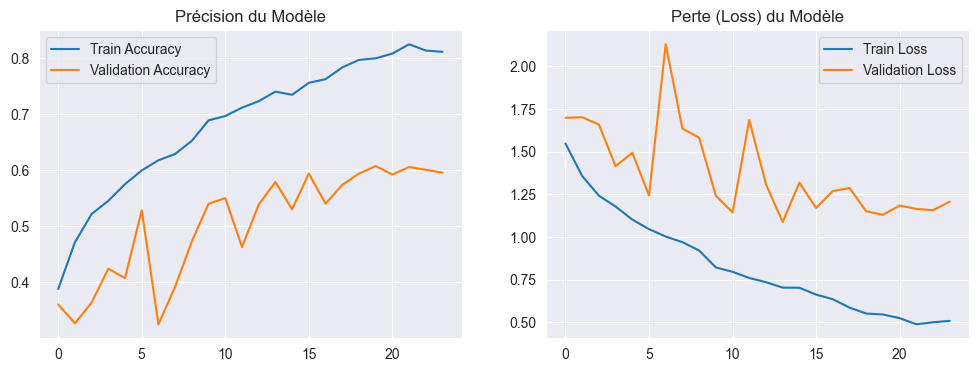

In [17]:
if not df.empty:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Précision du Modèle')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Perte (Loss) du Modèle')
    plt.legend()

    plt.show()

## 7. Évaluation et Matrice de Confusion
La matrice de confusion nous permet de voir où le modèle se trompe. Par exemple, est-ce qu'il confond souvent la "Peur" avec la "Surprise" ?

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6360 - loss: 1.0003
\nPrécision sur le jeu de TEST : 63.60%
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


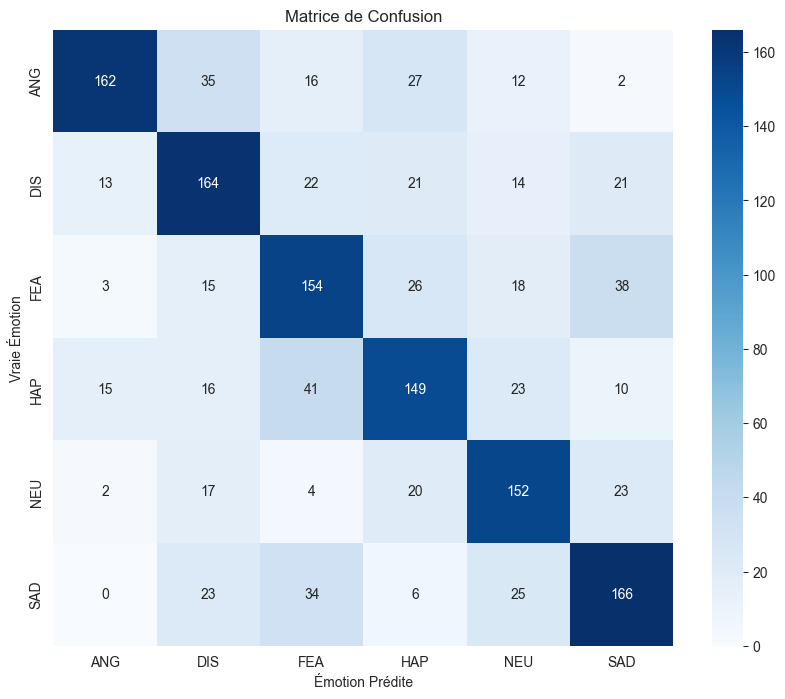

              precision    recall  f1-score   support

         ANG       0.83      0.64      0.72       254
         DIS       0.61      0.64      0.62       255
         FEA       0.57      0.61      0.59       254
         HAP       0.60      0.59      0.59       254
         NEU       0.62      0.70      0.66       218
         SAD       0.64      0.65      0.65       254

    accuracy                           0.64      1489
   macro avg       0.64      0.64      0.64      1489
weighted avg       0.64      0.64      0.64      1489



In [18]:
if not df.empty:
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\\nPrécision sur le jeu de TEST : {acc*100:.2f}%")

    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Matrice de confusion
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Émotion')
    plt.xlabel('Émotion Prédite')
    plt.show()

    # Rapport détaillé
    print(classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_))

## 8. Sauvegarde et Test Unitaire
Nous sauvegardons le modèle au format `.h5` pour pouvoir le réutiliser plus tard sans réentraîner.

In [19]:
if not df.empty:
    model.save("emotion_recognition_model.h5")
    print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


In [20]:
# Fonction pour tester le modèle sur un fichier audio spécifique
def predict_single_file(file_path):
    processed_audio = extract_features(file_path)
    if processed_audio is not None:
        # Ajout de la dimension batch (1, time, features)
        input_data = np.expand_dims(processed_audio, axis=0)
        prediction = model.predict(input_data)

        predicted_index = np.argmax(prediction)
        confidence = np.max(prediction)

        return lb.classes_[predicted_index], confidence
    return "Erreur", 0.0

In [21]:
# Exemple d'utilisation (décommentez et mettez un chemin valide)
emo, conf = predict_single_file("./AudioWAV/1001_DFA_ANG_XX.wav")
print(f"Émotion détectée : {emo} ({conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Émotion détectée : ANG (0.51)
